In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

## Loading the Data

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/NLP/labeled_data.csv')
df.drop(['count','hate_speech','offensive_language','neither'],axis=1,inplace=True)
df.head()


,Unnamed: 0,class,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


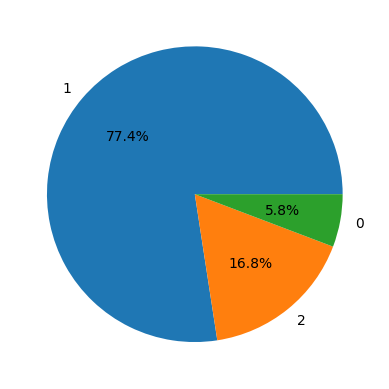

In [ ]:
plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


**The three labels are as follows:**

*   0 - Hate Speech

*   1 - Offensive Language
*  2 - Neither




The data Imbalance will be handled before training

## Text Preprocessing

In [ ]:
# Lower case all the words of the tweet before any preprocessing
df['tweet'] = df['tweet'].str.lower()

# Removing punctuations present in the text
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()


,Unnamed: 0,class,tweet
0,0,2,rt mayasolovely as a woman you shouldnt compl...
1,1,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,2,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,3,1,rt cganderson vivabased she look like a tranny
4,4,1,rt shenikaroberts the shit you hear about me ...


In [ ]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():

		if word not in stop_words:

			# Let's Lemmatize the word as well
			# before appending to the imp_words list.

			lemmatizer = WordNetLemmatizer()
			lemmatizer.lemmatize(word)

			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()


,Unnamed: 0,class,tweet
0,0,2,rt mayasolovely woman shouldnt complain cleani...
1,1,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,2,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,1,rt cganderson vivabased look like tranny
4,4,1,rt shenikaroberts shit hear might true might f...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24783 non-null  int64 
 1   class       24783 non-null  int64 
 2   tweet       24783 non-null  object
dtypes: int64(2), object(1)
memory usage: 581.0+ KB


Visualizing the text using Word Cloud

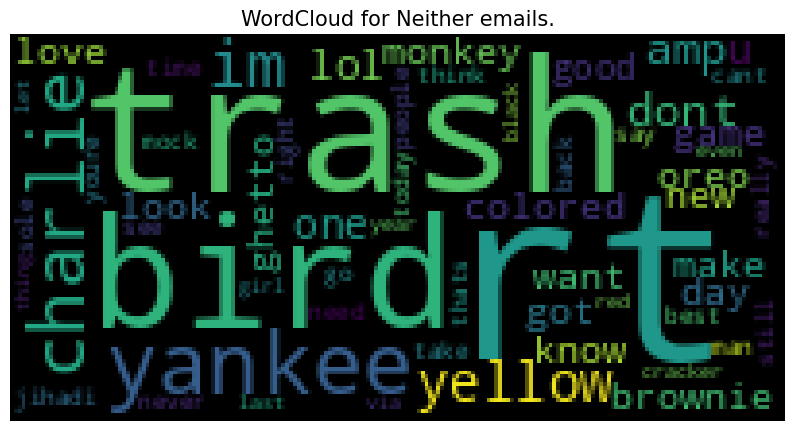

In [ ]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
          width = 200,
          height = 100,
          collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')


Dealing with the Imbalance in the Dataset

In [ ]:
#Using a mixture of Down Sampling and Up Sampling
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)


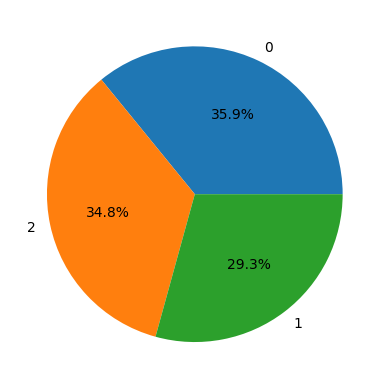

In [ ]:
plt.pie(balanced_df['class'].value_counts().values,
		labels=balanced_df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()


## Word Embeddings

In [ ]:
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features,
												target,
												test_size=0.2,
												random_state=22)
X_train.shape, X_val.shape


((9562,), (2391,))

In [ ]:
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape


((9562, 3), (2391, 3))

In [ ]:
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')

token.fit_on_texts(X_train)


In [ ]:
# training the tokenizer
max_words = 5000
token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')
token.fit_on_texts(X_train)

#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
							maxlen=50,
							padding='post',
							truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
							maxlen=50,
							padding='post',
							truncating='post')


Model Development and Evaluation

In [ ]:
model = keras.models.Sequential([
	layers.Embedding(max_words, 32, input_length=50),
	layers.Bidirectional(layers.LSTM(16)),
	layers.Dense(512, activation='relu', kernel_regularizer='l1'),
	layers.BatchNormalization(),
	layers.Dropout(0.3),
	layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
			optimizer='adam',
			metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

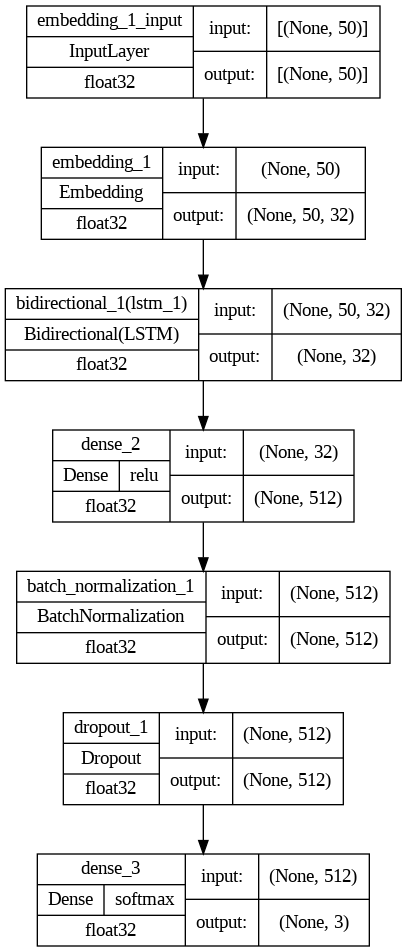

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes=True,
	show_dtype=True,
	show_layer_activations=True
)


In [ ]:
#To avoid overfitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


Training the Model

In [ ]:
history = model.fit(Training_pad, Y_train,
					validation_data=(Testing_pad, Y_val),
					epochs=50,
					verbose=1,
					batch_size=32,
					callbacks=[lr, es])


Epoch 1/50
299/299 [==============================] - 29s 61ms/step - loss: 1.7779 - accuracy: 0.7408 - val_loss: 1.0216 - val_accuracy: 0.5496 - lr: 0.0010
Epoch 2/50
299/299 [==============================] - 5s 16ms/step - loss: 0.3712 - accuracy: 0.8998 - val_loss: 0.5515 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 3/50
299/299 [==============================] - 6s 19ms/step - loss: 0.2884 - accuracy: 0.9261 - val_loss: 0.4790 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 4/50
299/299 [==============================] - 4s 14ms/step - loss: 0.2247 - accuracy: 0.9454 - val_loss: 0.7212 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 5/50
299/299 [==============================] - 4s 12ms/step - loss: 0.1965 - accuracy: 0.9547 - val_loss: 0.5185 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 6/50
299/299 [==============================] - 4s 14ms/step - loss: 0.1325 - accuracy: 0.9713 - val_loss: 0.4812 - val_accuracy: 0.8783 - lr: 5.0000e-04
Epoch 7/50
299/299 [==============================] - 3s 11

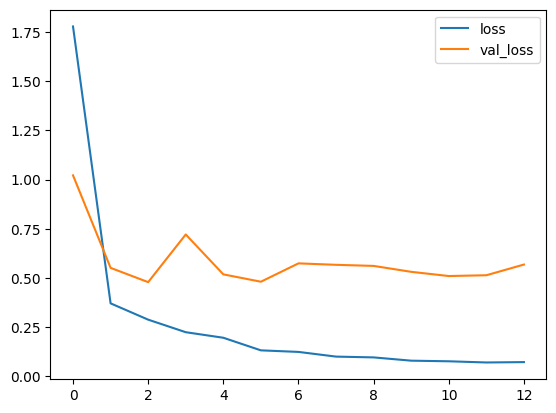

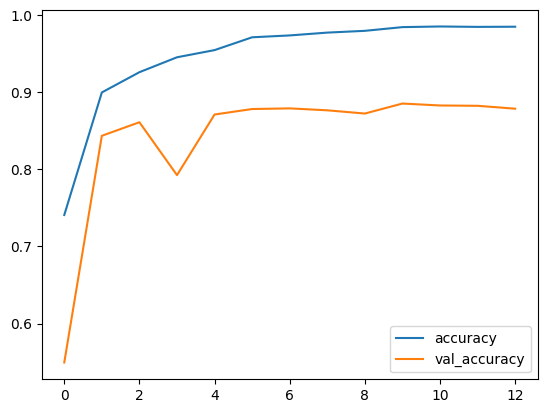

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()


In [ ]:
#Saving the model and the tokenizer
model.save('/content/gdrive/My Drive/NLP/hate_speech_model.h5')

from pickle import dump
dump(token, open( '/content/gdrive/My Drive/NLP/hate_speech_tokenizer.pkl' , 'wb' ))

Testing the Model on new data

In [ ]:
def predict_class(model, tokenizer, text):
    # Tokenize and pad the input text
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=50, padding='post', truncating='post')

    # Make predictions
    predictions = model.predict(text_pad)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map predicted class to the corresponding label
    class_labels = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
    predicted_label = class_labels[predicted_class]

    return predicted_label


In [ ]:
tweet = "You ever fuck a bitch and she start to cry? You be confused as shit"
tweet2 = "The shit you hear about me might be true or it might be faker than the bitch who told it to ya"
predict_class(model,token,tweet)

1/1 [==============================] - 5s 5s/step


'Offensive Language'

In [ ]:
predict_class(model,token,tweet)

## Using Pre-trained Transformers

In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['tweet'].tolist(), df['class'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
# Load pretrained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize and preprocess the data
max_len = 128  # You can adjust this based on your requirements

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_len, return_tensors='tf')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_len, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels, dtype=tf.int32)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels, dtype=tf.int32)
))

In [ ]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Training
epochs = 3  # You can adjust this based on your requirements

model.fit(train_dataset.shuffle(1000).batch(32), epochs=epochs)

Epoch 1/3
620/620 [==============================] - 560s 792ms/step - loss: 0.3152 - accuracy: 0.8905
Epoch 2/3
620/620 [==============================] - 489s 789ms/step - loss: 0.2128 - accuracy: 0.9227
Epoch 3/3
620/620 [==============================] - 488s 787ms/step - loss: 0.1668 - accuracy: 0.9395


In [ ]:
# Evaluate on the test set
results = model.evaluate(test_dataset.batch(32))
print("Test accuracy:", results[1])

155/155 [==============================] - 47s 303ms/step - loss: 0.2793 - accuracy: 0.9090
Test accuracy: 0.9090175628662109


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
logits = model.predict(test_dataset.batch(32))['logits']
predictions = np.argmax(logits, axis=-1)  # Use axis=-1 to automatically choose the last dimension

# Classification Report
class_report = classification_report(test_labels, predictions)

print("\nClassification Report:\n", class_report)

155/155 [==============================] - 41s 266ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.22      0.32       290
           1       0.93      0.97      0.95      3832
           2       0.87      0.88      0.87       835

    accuracy                           0.91      4957
   macro avg       0.79      0.69      0.71      4957
weighted avg       0.90      0.91      0.90      4957



In [ ]:
#predictions
def get_predictions(text, model, tokenizer,max_len=128):

    label_mapping = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}

    # Tokenize and preprocess the data
    encodings = tokenizer([text], truncation=True, padding=True, max_length=max_len, return_tensors='tf')

    # Get model predictions
    logits = model.predict(dict(encodings))
    prediction = np.argmax(logits['logits'], axis=1)

    # Map predictions to string labels
    predicted_label = label_mapping[int(prediction)]

    return predicted_label

In [ ]:
text = 'The shit you hear about me might be true or it might be faker than the bitch who told it to ya'
get_predictions(text,model,tokenizer)

1/1 [==============================] - 0s 71ms/step


'Offensive Language'

In [ ]:
#saving the model
model.save_pretrained('/content/gdrive/My Drive/NLP/bert_hate_speech_model')

In [ ]:
#saving the tokenizer
tokenizer.save_pretrained('/content/gdrive/My Drive/NLP/bert_hate_speech_tokenizer')

('/content/gdrive/My Drive/NLP/bert_hate_speech_tokenizer/tokenizer_config.json',
 '/content/gdrive/My Drive/NLP/bert_hate_speech_tokenizer/special_tokens_map.json',
 '/content/gdrive/My Drive/NLP/bert_hate_speech_tokenizer/vocab.txt',
 '/content/gdrive/My Drive/NLP/bert_hate_speech_tokenizer/added_tokens.json')